# TP: Cuidado! Lluvia de Hamburguesas - Parte 1

## Grupo 4
Integrantes:
- Flouret, Agustín Miguel - 102298
- Milhas, Facundo - 102727

In [1]:
import numpy as np
import pandas as pd
import matplotlib 
from matplotlib import pyplot as plt
import seaborn as sns

## Introducción
En este trabajo analizaremos datos climáticos recolectados en la Ciudad de Buenos Aires con el objetivo de predecir si lloverán hamburguesas al dia siguiente. En primer lugar buscaremos patrones en los datos mediante la realización y análisis de gráficos de los features del dataset. En base al análisis hecho, implementaremos un algoritmo básico para poder predecir la variable target con un *accuracy* mayor al 80%.

## Carga y limpieza del dataset

Inicialmente obtenemos los datasets de los features y de la variable target, y creamos los dataframes correspondientes.

In [2]:
from collections import Counter
import requests

with requests.get(
    "https://docs.google.com/spreadsheets/d/1wduqo5WyYmCpaGnE81sLNGU0VSodIekMfpmEwU0fGqs/export?format=csv") as r, open("features.csv", "wb") as f:
    for chunk in r.iter_content():
        f.write(chunk)

with requests.get(
    "https://docs.google.com/spreadsheets/d/1gvZ03uAL6THwd04Y98GtIj6SeAHiKyQY5UisuuyFSUs/export?format=csv") as r, open("target.csv", "wb") as f:
    for chunk in r.iter_content():
        f.write(chunk)

In [3]:
df_features = pd.read_csv("features.csv")

/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
df_target = pd.read_csv("target.csv")

Unimos la tabla donde se encuentra nuestro valor target (la variable booleana que indica si llovieron o no hamburguesas al dia siguiente) con la tabla de features, todo en un mismo dataframe, a través del id.

In [5]:
df = df_features.merge(df_target, on='id')

Imprimimos las primeras filas del dataframe, probando que la lectura haya sido correcta, viendo el tipo de datos.

In [6]:
df.head()

,barrio,dia,direccion_viento_tarde,direccion_viento_temprano,horas_de_sol,humedad_tarde,humedad_temprano,id,llovieron_hamburguesas_hoy,mm_evaporados_agua,...,presion_atmosferica_temprano,rafaga_viento_max_direccion,rafaga_viento_max_velocidad,temp_max,temp_min,temperatura_tarde,temperatura_temprano,velocidad_viendo_tarde,velocidad_viendo_temprano,llovieron_hamburguesas_al_dia_siguiente
0,Retiro,2016-10-11,Este,Nornoreste,10.7,59.0,56.0,86942,no,16.0,...,1010.2,Estesureste,33.0,29.2,16.8,24.1,25.3,19.0,4.0,no
1,Vélez Sársfield,2016-03-28,Sur,suroeste,0.0,49.0,83.0,102098,no,2.6,...,1021.4,Sur,31.0,16.9,10.6,16.4,12.3,13.0,7.0,no
2,Palermo,2017-05-11,Sursureste,Norte,4.3,59.0,83.0,67154,no,2.4,...,1026.5,Norte,26.0,16.6,4.4,15.7,9.4,9.0,13.0,no
3,Mataderos,2012-05-07,suroeste,Sur,NaN,67.0,93.0,50245,no,NaN,...,1020.0,Oestesuroeste,13.0,11.4,0.8,11.1,4.0,6.0,6.0,no
4,Recoleta,2014-06-19,Nornoreste,Nornoreste,0.8,94.0,97.0,82904,no,0.8,...,1021.9,Nornoreste,33.0,11.6,6.7,11.2,8.8,11.0,15.0,no


Imprimimos los dtypes del dataframe leido. Esta funcion nos devuelve una Serie con el tipo de datos de cada columna. El índice del resultado son las columnas del dataframe original. Las columnas con tipos mixtos se almacenan con el dtype 'object'.

In [7]:
df.dtypes

barrio                                      object
dia                                         object
direccion_viento_tarde                      object
direccion_viento_temprano                   object
horas_de_sol                               float64
humedad_tarde                              float64
humedad_temprano                           float64
id                                           int64
llovieron_hamburguesas_hoy                  object
mm_evaporados_agua                         float64
mm_lluvia_dia                              float64
nubosidad_tarde                            float64
nubosidad_temprano                         float64
presion_atmosferica_tarde                   object
presion_atmosferica_temprano               float64
rafaga_viento_max_direccion                 object
rafaga_viento_max_velocidad                float64
temp_max                                   float64
temp_min                                   float64
temperatura_tarde              

Podemos observar como la columna de 'presion_atmosferica_tarde' figura con el tipo de dato object, cuando deberia ser del tipo float64. Esto se debe a que contiene valores basura. Convertimos el tipo de la columna a un tipo numérico, y  establecimos los valores inválidos como NaN.

In [8]:
df['presion_atmosferica_tarde'] = pd.to_numeric(df['presion_atmosferica_tarde'],errors='coerce')

Convertimos la columna con fechas de object al tipo de dato datetime.

In [9]:
df['dia'] = pd.to_datetime(df['dia'])

Verificamos aquellos valores que sean negativos haciendo una tabla. Observamos que solo se encuentran valores negativos en las columnas de las tempreaturas, lo cual corresponde.

In [10]:
columnas_con_numeros = ['horas_de_sol', 'humedad_tarde', 'humedad_temprano', 'id', 'mm_evaporados_agua', 'mm_lluvia_dia', 'nubosidad_tarde', 'nubosidad_temprano', 'presion_atmosferica_temprano', 'presion_atmosferica_tarde', 'rafaga_viento_max_velocidad', 'temp_max', 'temp_min', 'temperatura_tarde', 'temperatura_temprano', 'velocidad_viendo_tarde', 'velocidad_viendo_temprano']

(df[columnas_con_numeros] < 0).any().to_frame('Valores negativos?')

,Valores negativos?
horas_de_sol,False
humedad_tarde,False
humedad_temprano,False
id,False
mm_evaporados_agua,False
mm_lluvia_dia,False
nubosidad_tarde,False
nubosidad_temprano,False
presion_atmosferica_temprano,False
presion_atmosferica_tarde,False


### Missings
Ahora analizamos los valores faltantes.

In [11]:
(df.isnull().mean() * 100).to_frame("Porcentaje de missings").sort_values("Porcentaje de missings", ascending=False)

,Porcentaje de missings
horas_de_sol,47.999450
mm_evaporados_agua,43.148460
nubosidad_tarde,40.775815
nubosidad_temprano,38.374811
presion_atmosferica_temprano,10.328441
presion_atmosferica_tarde,10.313832
direccion_viento_temprano,7.221057
rafaga_viento_max_direccion,7.105905
rafaga_viento_max_velocidad,7.062079
humedad_tarde,3.089337


Observamos que la variable target tiene un 2.27% de datos faltantes. Dado que es la variable que queremos predecir, eliminamos todas las filas del dataframe donde haya valores faltantes en esta columna.

In [12]:
df = df.dropna(subset=['llovieron_hamburguesas_al_dia_siguiente'])

Tambien podemos ver que hay un gran porcentaje de datos faltantes en las columnas "horas_de_sol", "mm_evaporados_agua", "nubosidad_tarde" y "nubosidad_temprano".

Graficando los valores existentes de estas columnas en función de los barrios, podemos observar que hay barrios donde no se registró ningún valor. Este patrón sucede en las 4 variables, con lo cual los missings no son completamente aleatorios.

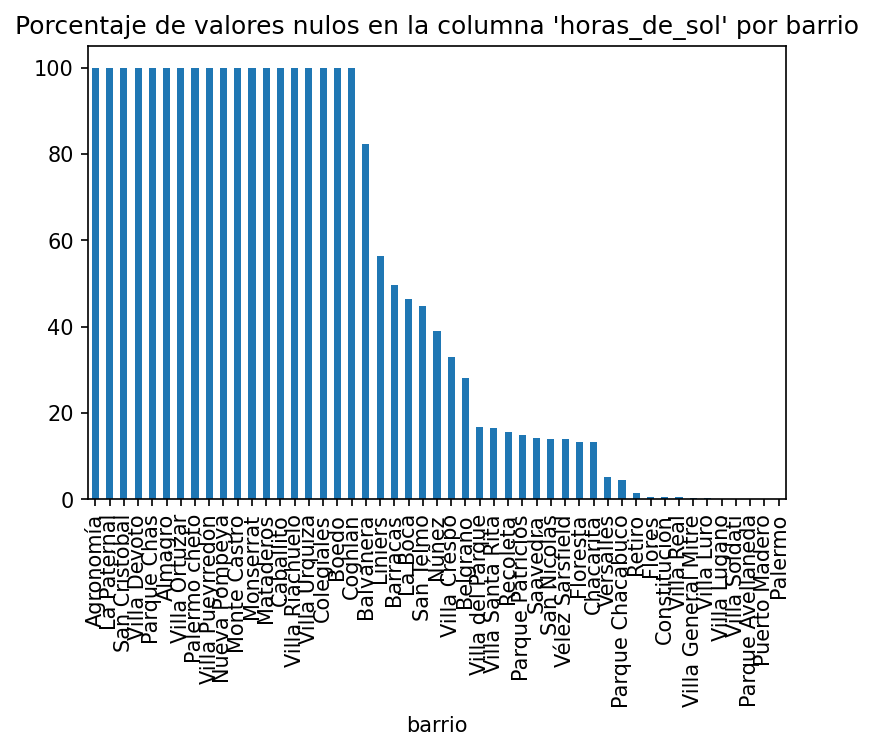

In [13]:
plt.rcParams["figure.dpi"] = 150

plt.figure(dpi=150)
((df[df['horas_de_sol'].isnull()].groupby('barrio').size() / df.groupby('barrio').size())*100).sort_values(ascending = False).plot(kind = 'bar')
plt.title("Porcentaje de valores nulos en la columna 'horas_de_sol' por barrio")
plt.show()



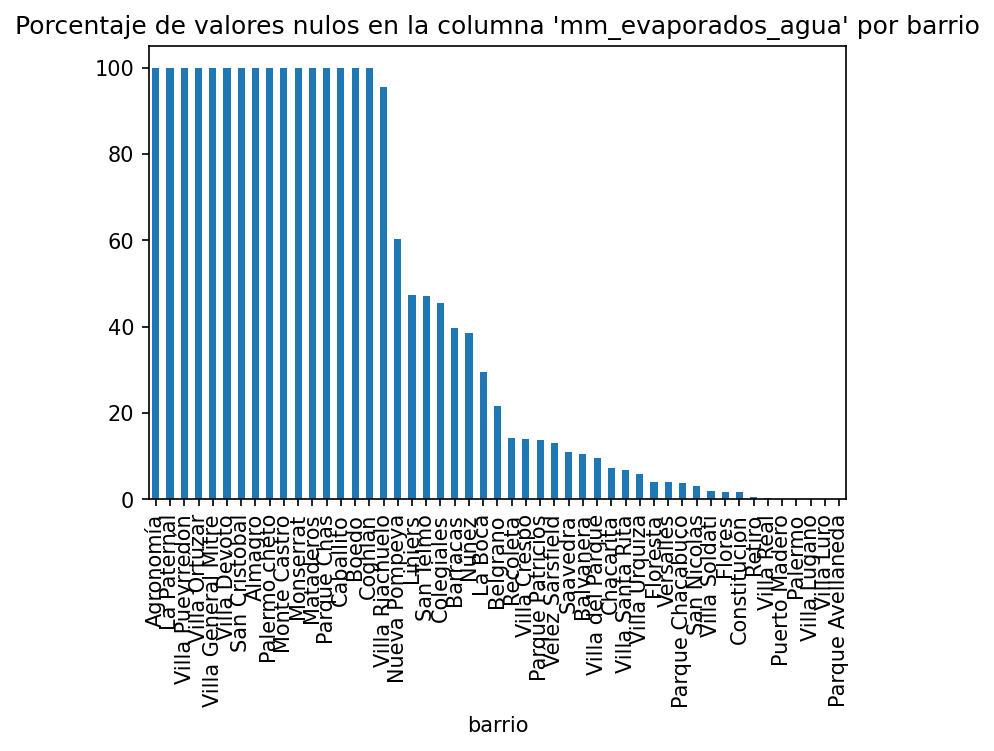

In [14]:
plt.figure(dpi=150)
((df[df['mm_evaporados_agua'].isnull()].groupby('barrio').size() / df.groupby('barrio').size())*100).sort_values(ascending = False).plot(kind = 'bar')
plt.title("Porcentaje de valores nulos en la columna 'mm_evaporados_agua' por barrio")

plt.show()


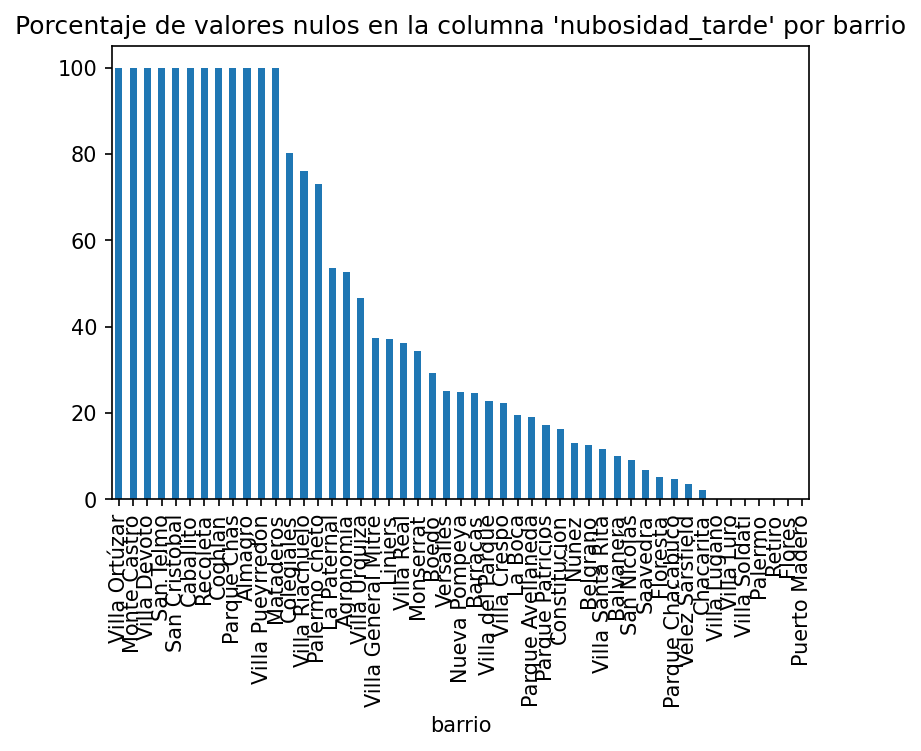

In [15]:
plt.figure(dpi=150)
((df[df['nubosidad_tarde'].isnull()].groupby('barrio').size() / df.groupby('barrio').size())*100).sort_values(ascending = False).plot(kind = 'bar')
plt.title("Porcentaje de valores nulos en la columna 'nubosidad_tarde' por barrio")

plt.show()


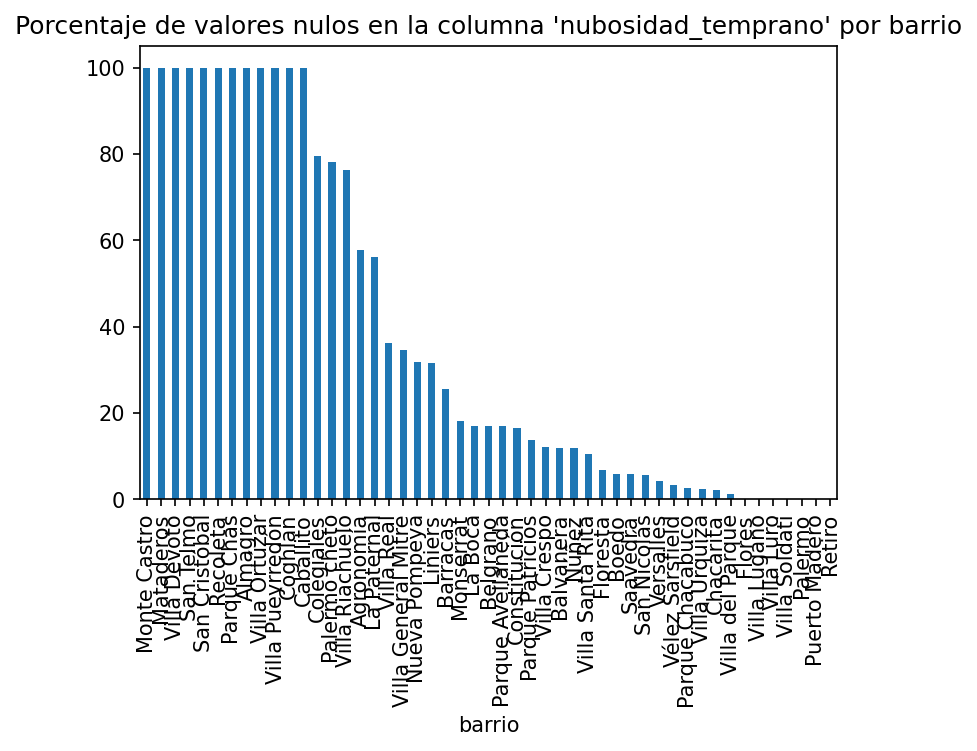

In [16]:
plt.figure(dpi=150)
((df[df['nubosidad_temprano'].isnull()].groupby('barrio').size() / df.groupby('barrio').size())*100).sort_values(ascending = False).plot(kind = 'bar')
plt.title("Porcentaje de valores nulos en la columna 'nubosidad_temprano' por barrio")

plt.show()

Es probable que la causa de los valores faltantes sea que en algunos barrios se tomaron menos muestras (o ninguna) de dichos features. De hecho, en los gráficos se observa que cuanto mayor es el porcentaje de missings, mayor es la cantidad de barrios que no registraron ningún valor.

Una opción para tratar este problema es eliminar las columnas que tienen una alta proporción de missings. Sin embargo, creemos que estas columnas pueden ser útiles para predecir la variable target. Además, si los missings dependen del barrio, y suponiendo que el barrio no es una variable importante para predecir la lluvia de hamburguesas, consideramos que los datos faltantes no afectan mucho el resultado del analisis. Por lo tanto, no eliminamos ninguna columna. Sin embargo, como contamos con menos muestras, en el baseline se le dará menor importancia a estas variables.

Dado que en este trabajo no utilizaremos algoritmos de machine learning, consideramos que no es necesario completar los valores faltantes con otro valor.

Ahora analizaremos las filas que tienen un alto porcentaje de missings (más del 40%):

In [17]:
df[df.isnull().mean(1) > 0.4]

,barrio,dia,direccion_viento_tarde,direccion_viento_temprano,horas_de_sol,humedad_tarde,humedad_temprano,id,llovieron_hamburguesas_hoy,mm_evaporados_agua,...,presion_atmosferica_temprano,rafaga_viento_max_direccion,rafaga_viento_max_velocidad,temp_max,temp_min,temperatura_tarde,temperatura_temprano,velocidad_viendo_tarde,velocidad_viendo_temprano,llovieron_hamburguesas_al_dia_siguiente
286,Monte Castro,2008-12-13,NaN,Oestenoroeste,NaN,NaN,100.0,52074,si,NaN,...,NaN,NaN,NaN,13.8,6.0,NaN,9.1,NaN,37.0,si
290,Coghlan,2010-02-20,Noreste,NaN,NaN,42.0,NaN,24573,NaN,NaN,...,NaN,Nornoreste,31.0,31.3,16.5,30.2,NaN,19.0,NaN,no
315,Boedo,2015-08-23,NaN,NaN,NaN,NaN,94.0,17443,si,NaN,...,NaN,NaN,NaN,16.2,14.2,NaN,15.0,NaN,0.0,si
322,Boedo,2010-10-12,NaN,NaN,NaN,NaN,NaN,15756,no,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no
325,Boedo,2016-10-29,NaN,NaN,NaN,NaN,94.0,17876,si,NaN,...,NaN,NaN,NaN,26.0,15.8,NaN,18.0,NaN,0.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116122,Liniers,2009-11-19,NaN,NaN,NaN,9.0,44.0,46336,no,6.2,...,NaN,NaN,NaN,39.2,12.9,37.5,22.0,NaN,NaN,no
116162,Villa Pueyrredón,2012-01-09,NaN,NaN,NaN,NaN,NaN,127902,no,NaN,...,1022.4,NaN,NaN,NaN,13.9,18.9,18.1,19.0,6.0,no
116177,Villa General Mitre,2009-07-19,NaN,NaN,3.6,NaN,NaN,114819,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,si
116214,Barracas,2014-06-05,NaN,NaN,NaN,60.0,93.0,10950,si,NaN,...,NaN,NaN,NaN,20.1,13.4,19.8,15.3,NaN,NaN,no


Dado que estas son aproximadamente el 1% del total de filas, las podemos eliminar.

In [18]:
df = df[df.isnull().mean(1) < 0.4]

# Visualizacion y análisis de los datos


Ahora realizaremos gráficos para visualizar los datos y encontrar patrones. Nos guiamos por las siguientes preguntas:

1. Si un dia llueven hamburguesas, ¿llueven hamburguesas al día siguiente?
2. ¿Cómo se relaciona la lluvia con la lluvia de hamburguesas?
3. ¿Cómo se relacionan las distintas temperaturas entre sí? ¿Hay alguna relación con la lluvia de hamburguesas?
4. ¿Cómo se relaciona la humedad con la lluvia de hamburguesas?
5. ¿Cómo se relaciona la nubosidad con la lluvia de hamburguesas?
6. ¿Cómo se relaciona el viento con la lluvia de hamburguesas?
7. ¿Cómo se relaciona la presión atmosférica con la lluvia de hamburguesas?
8. ¿Cómo se relaciona los milimetros evaporados de agua con la lluvia de hamburguesas?
9. ¿Cómo se relaciona las horas de sol con la lluvia de hamburguesas?
10. ¿Cómo varía el clima segun el barrio?
11. ¿Cómo varia el clima según la fecha?

In [19]:
plt.rcParams["figure.dpi"] = 150

## 1. Si un dia llueven hamburguesas, ¿llueven hamburguesas al día siguiente?

Antes de tratar de responder la pregunta, analizamos la variable target en forma independiente, realizando un grafico de torta. Vemos que, en la mayoria de los casos registrados en el dataset, no llovieron hamburguesas al dia siguiente.

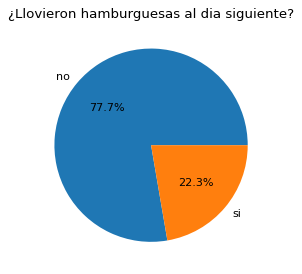

In [20]:
plt.figure(dpi=80)
df['llovieron_hamburguesas_al_dia_siguiente'].value_counts().plot(
    kind='pie',
    autopct='%1.1f%%',
    ylabel='',
    title='¿Llovieron hamburguesas al dia siguiente?'
)
plt.show()

Para responder la pregunta, analizamos la probabilidad de que llueva dos dias consecutivos. Graficamos los porcentajes de dias que llueven, o no, hamburguesas al dia siguiente, habiendo llovido hamburguesas ese dia. 

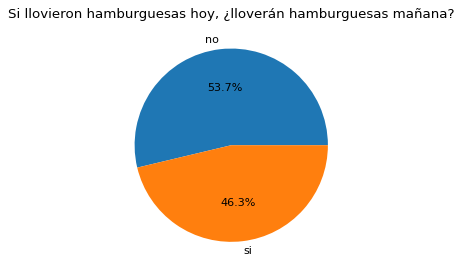

In [21]:
plt.figure(dpi=80)
df[df['llovieron_hamburguesas_hoy']=='si']['llovieron_hamburguesas_al_dia_siguiente'].value_counts().plot(
    kind='pie',
    autopct='%1.1f%%',
    ylabel='',
    title='Si llovieron hamburguesas hoy, ¿lloverán hamburguesas mañana?'   
)
plt.show()

Observamos que cuando llueve, al dia siguiente llueve también en el 46.4% de los casos. Ahora vemos qué pasa cuando no llueven hamburguesas ese día.

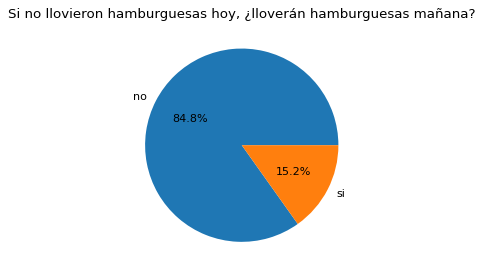

In [22]:
plt.figure(dpi=80)
df[df['llovieron_hamburguesas_hoy']=='no']['llovieron_hamburguesas_al_dia_siguiente'].value_counts().plot(
    kind='pie',
    autopct='%1.1f%%',
    ylabel='',
    title='Si no llovieron hamburguesas hoy, ¿lloverán hamburguesas mañana?'   
)
plt.show()

En este caso, al día siguiente solamente llueve el 15.2% de las veces.

Podemos ver que la probabilidad de que lluevan hamburguesas al día siguiente es 3 veces mayor cuando llueven hamburguesas ese día que cuando no llueven hamburguesas ese día.

Por otro lado, observamos que el 77.6% de las veces no llovieron hamburguesas. Esto significa que, si nuestra predicción fuera que nunca van a llover hamburguesas al día siguiente, lograríamos un 77.6% de accuracy. Esta conclusión será importante más adelante, al implementar el algoritmo baseline.

## 2. ¿Como se relacionan los mm de lluvia con la lluvia de hamburguesas?

Al mirar el dataset, surge una duda: ¿la columna 'mm_lluvia_dia' hace referencia a la lluvia de hamburguesas o a la lluvia de agua? Debido a la unidad utilizada, se puede asumir que se refiere a la cantidad de agua que cae en un día, aunque es lógico pensar que esto podría estar fuertemente relacionado con la lluvia de hamburguesas.

Primero graficamos la distribución de los mm de lluvia por dia. Se espera que haya una gran cantidad de muestras con valor 0, ya que la mayoría de los días no llueve.

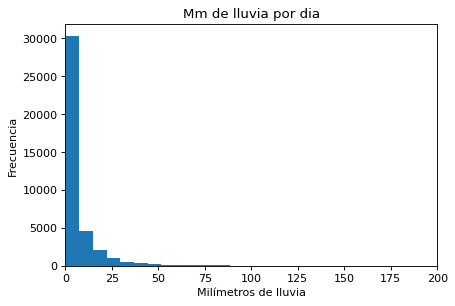

In [23]:
plt.figure(dpi=80)
df[df['mm_lluvia_dia']>0]['mm_lluvia_dia'].plot(
    kind='hist',
    xlim = (0, 200),
    bins=50,
    title='Mm de lluvia por dia'   
)
plt.xlabel('Milímetros de lluvia')
plt.ylabel('Frecuencia')
plt.show()

Observamos que, como era de esperar, en la gran mayoria de los casos la cantidad de lluvia que cae es muy baja o nula. 

Graficando un density plot entre 0 y 25, se observa que la densidad alcanza un máximo alrededor de 1 mm, y luego disminuye rápidamente.

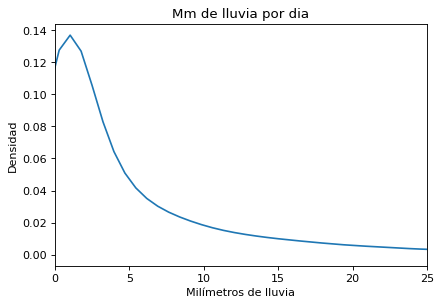

In [24]:
plt.figure(dpi=80)
df[df['mm_lluvia_dia']>0]['mm_lluvia_dia'].plot(
    kind='density',
    xlim = (0, 25),
    title='Mm de lluvia por dia'    
)
plt.xlabel('Milímetros de lluvia')
plt.ylabel('Densidad')
plt.show()

Ahora veremos si los milímetros diarios están relacionados con la lluvia de hamburguesas.

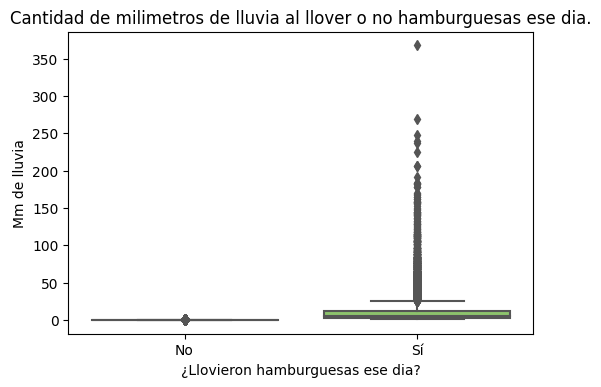

In [25]:
plt.figure(dpi=100)
plt.title("Cantidad de milimetros de lluvia al llover o no hamburguesas ese dia.")
sns.boxplot(
    data=df,
       
    y='mm_lluvia_dia',
    x='llovieron_hamburguesas_hoy',
    palette=['#D17049', "#89D15E"],
)
plt.xlabel('¿Llovieron hamburguesas ese dia?')
plt.ylabel("Mm de lluvia")
plt.xticks([False, True], ["No", "Sí"])
plt.show()

Observamos que, los días que no llovieron hamburguesas registran un valor de mm de lluvia igual a 0, exceptuando algunos outliers que poseen valores muy cercanos a 0. Por otro lado, en los días que sí llovieron hamburguesas se registraron valores siguiendo la distribución analizada anteriormente.

Por lo tanto, la lluvia de hamburguesas parece estar íntimamente ligada a los milímetros de lluvia diarios. 

Teniendo en cuenta esto, veremos si la cantidad de mm de lluvia de un día tienen alguna relación con si llueven o no hamburguesas al día siguiente. 

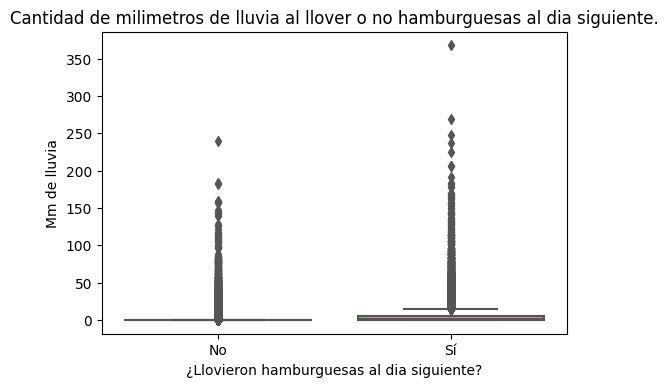

In [26]:
plt.figure(dpi=100)
plt.title("Cantidad de milimetros de lluvia al llover o no hamburguesas al dia siguiente.")
sns.boxplot(
    data=df,
    y='mm_lluvia_dia',
    x='llovieron_hamburguesas_al_dia_siguiente',
    palette=['#D17049', "#89D15E"],
)
plt.xlabel('¿Llovieron hamburguesas al dia siguiente?')
plt.ylabel("Mm de lluvia")
plt.xticks([False, True], ["No", "Sí"])
plt.show()

A partir del boxplot se puede inferir que en los días previos a que lluevan hamburguesas se registró una mayor cantidad de lluvia que cuando no llovieron hamburguesas.

Para cada caso, calculamos la media, con el fin de cuantificar esta relación:

In [27]:
df[['mm_lluvia_dia', 'llovieron_hamburguesas_al_dia_siguiente']].groupby('llovieron_hamburguesas_al_dia_siguiente').mean()

,mm_lluvia_dia
llovieron_hamburguesas_al_dia_siguiente,
no,1.261380
si,6.071635


Como conclusión de este análisis podemos decir que una alta cantidad de lluvia en un día puede indicar que al día siguiente van a llover hamburguesas.

## 3. ¿Cómo se relacionan las distintas temperaturas entre sí? ¿Hay alguna relación con la lluvia de hamburguesas?



En el dataset hay 4 columnas con datos de temperatura: máxima, mínima, tarde y temprano. En primer lugar analizaremos qué relación hay entre estos datos.

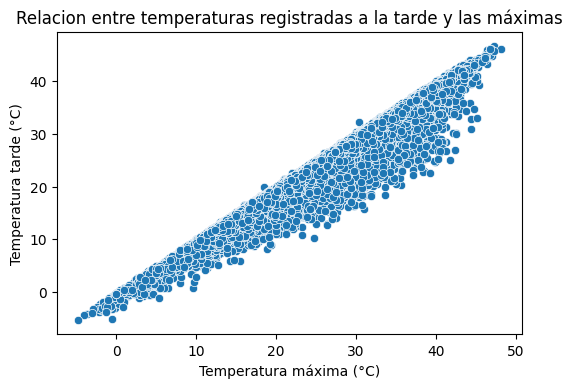

In [28]:
plt.figure(dpi=100)
sns.scatterplot(
    x=df['temp_max'],
    y=df['temperatura_tarde'],
)
plt.title('Relacion entre temperaturas registradas a la tarde y las máximas')
plt.xlabel('Temperatura máxima (°C)')
plt.ylabel('Temperatura tarde (°C)')
plt.show()

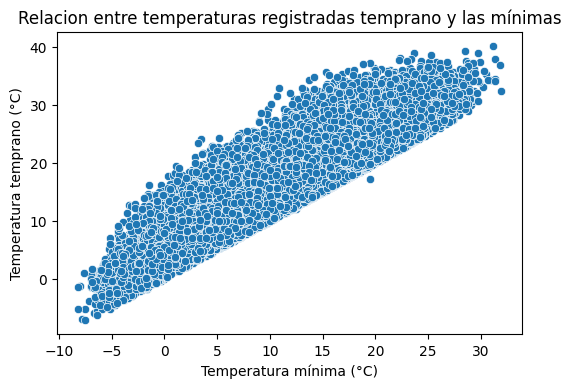

In [29]:
plt.figure(dpi=100)
sns.scatterplot(
    x=df['temp_min'],
    y=df['temperatura_temprano'],
)
plt.title('Relacion entre temperaturas registradas temprano y las mínimas')
plt.xlabel('Temperatura mínima (°C)')
plt.ylabel('Temperatura temprano (°C)')
plt.show()

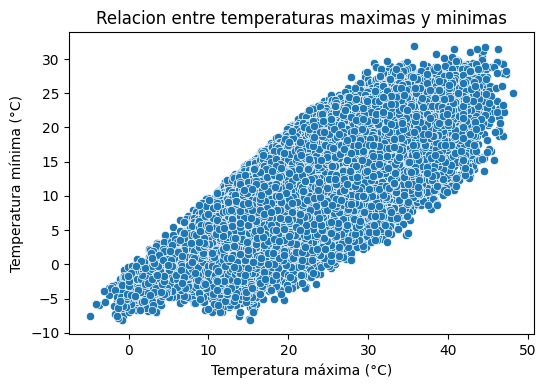

In [30]:
plt.figure(dpi=100)
sns.scatterplot(
    x=df['temp_max'],
    y=df['temp_min'],
)
plt.title( 'Relacion entre temperaturas maximas y minimas')
plt.xlabel('Temperatura máxima (°C)')
plt.ylabel('Temperatura mínima (°C)')
plt.show()

Parece haber una correlación alta entre la temperatura máxima y la temperatura de la tarde. En los otros casos, los datos están un poco más dispersos, con lo cual no hay una correlación tan alta como en el primer caso.

Dada la alta correlación entre temp_max y temperatura_tarde, solo analizaremos una de ellas con respecto a la variable target.

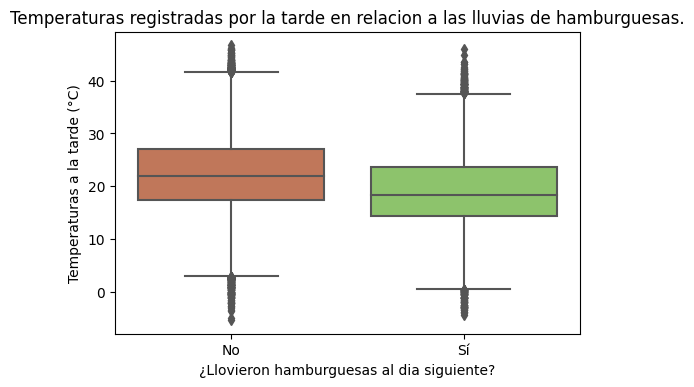

In [31]:
plt.figure(dpi=100)
plt.title("Temperaturas registradas por la tarde en relacion a las lluvias de hamburguesas.")
sns.boxplot(
    data=df,
       
    y='temperatura_tarde',
    x='llovieron_hamburguesas_al_dia_siguiente',
    palette=['#D17049', "#89D15E"],
)
plt.xlabel('¿Llovieron hamburguesas al dia siguiente?')
plt.ylabel("Temperaturas a la tarde (°C)")
plt.xticks([False, True], ["No", "Sí"])
plt.show()

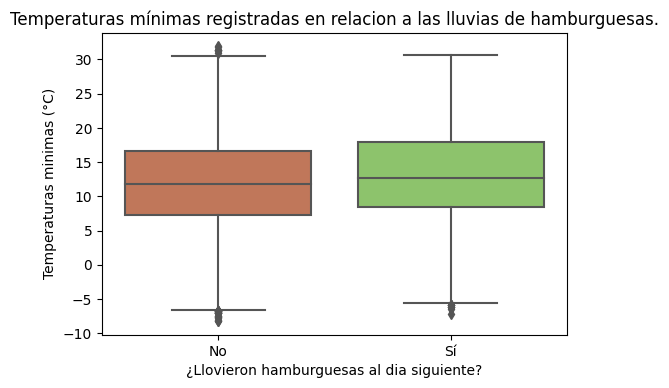

In [32]:
plt.figure(dpi=100)
plt.title("Temperaturas mínimas registradas en relacion a las lluvias de hamburguesas.")
sns.boxplot(
    data=df,
       
    y='temp_min',
    x='llovieron_hamburguesas_al_dia_siguiente',
    palette=['#D17049', "#89D15E"],
)
plt.xlabel('¿Llovieron hamburguesas al dia siguiente?')
plt.ylabel("Temperaturas minimas (°C)")
plt.xticks([False, True], ["No", "Sí"])
plt.show()

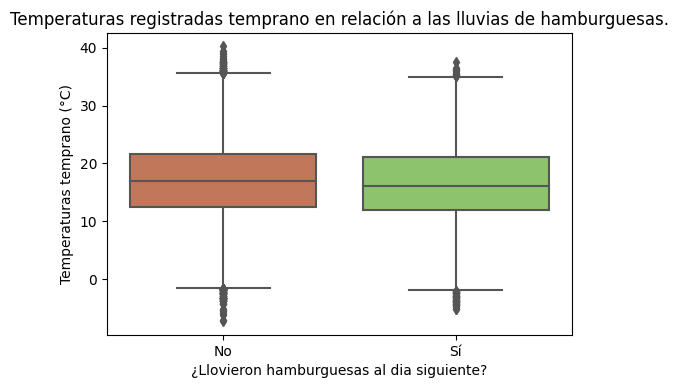

In [33]:
plt.figure(dpi=100)
plt.title("Temperaturas registradas temprano en relación a las lluvias de hamburguesas.")
sns.boxplot(
    data=df,
       
    y='temperatura_temprano',
    x='llovieron_hamburguesas_al_dia_siguiente',
    palette=['#D17049', "#89D15E"],
)
plt.xlabel('¿Llovieron hamburguesas al dia siguiente?')
plt.ylabel("Temperaturas temprano (°C)")
plt.xticks([False, True], ["No", "Sí"])
plt.show()

En la temperatura temprano y la temperatura minima no se observaron diferencias significativas. 

En el caso de la temperatura tarde, aunque la diferencia que se observa es ligeramente mayor, no consideramos que sea suficiente como para realizar una predicción sobre la lluvia de hamburguesas al día siguiente en base a estos datos.

## 4. ¿Como se relaciona la humedad con la lluvia de hamburguesas?

Queremos obtener una conclusión acerca de la importancia del nivel de humedad a la hora de determinar si lloverán hamburguesas al dia siguiente. Primero graficamos la función de densidad de probabilidad de la variable 'humedad_tarde'.

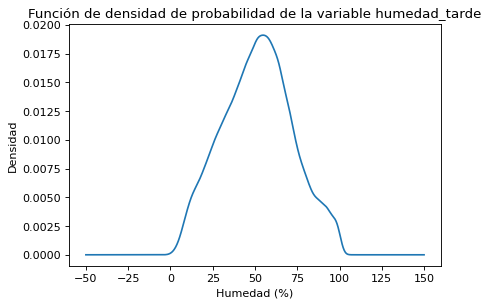

In [34]:
plt.figure(dpi=80)
df['humedad_tarde'].plot(kind='density',title= 'Función de densidad de probabilidad de la variable humedad_tarde')
plt.xlabel('Humedad (%)')
plt.ylabel('Densidad')
plt.show()

La humedad relativa del aire se define como el cociente entre la humedad que contiene el aire y la humedad de saturación, expresado en tanto por ciento %. Podemos ver que los valores medidos de humedad alcanzan su mayor densidad alrededor del 50%.

Luego, revisamos su relación con la humedad a la tarde.

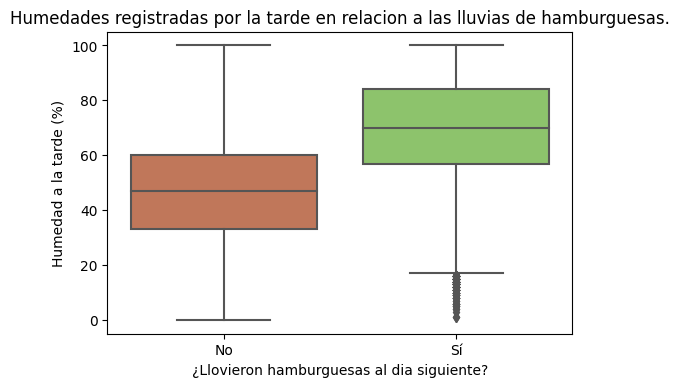

In [35]:
plt.figure(dpi=100)
plt.title("Humedades registradas por la tarde en relacion a las lluvias de hamburguesas.")
sns.boxplot(
    data=df,
    y='humedad_tarde',
    x='llovieron_hamburguesas_al_dia_siguiente',
    palette=['#D17049', "#89D15E"],
)
plt.xlabel('¿Llovieron hamburguesas al dia siguiente?')
plt.ylabel("Humedad a la tarde (%)")
plt.xticks([False, True], ["No", "Sí"])
plt.show()

Se puede observar que cuando la humedad de la tarde es mayor al 60%, se concentran mucho los valores en lo que 'llovieron_hamburguesas_al_dia_siguiente' es 'si', es decir, hay una alta probabilidad de que lluevan hamburguesas al dia siguiente.

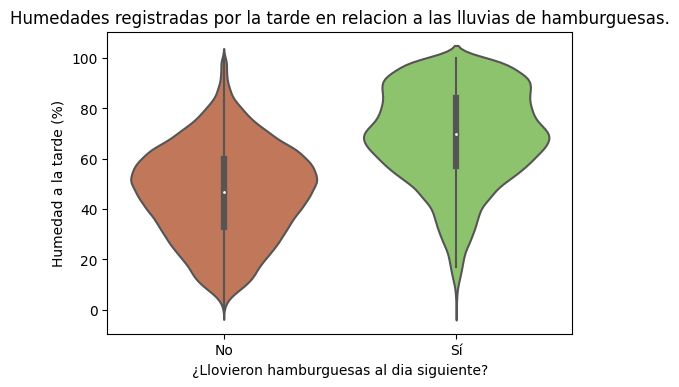

In [36]:
plt.figure(dpi=100)
plt.title("Humedades registradas por la tarde en relacion a las lluvias de hamburguesas.")
sns.violinplot(
    data=df,
    y='humedad_tarde',
    x='llovieron_hamburguesas_al_dia_siguiente',
    palette=['#D17049', "#89D15E"],
)
plt.xlabel('¿Llovieron hamburguesas al dia siguiente?')
plt.ylabel("Humedad a la tarde (%)")
plt.xticks([False, True], ["No", "Sí"])
plt.show()

En particular, en el violin plot podemos ver que para humedades mayores a 80, la densidad de la variable en el caso de 'si' se eleva mientras que en el caso 'no' es casi nula.

Ahora vemos la relación entre la humedad temprana con la variable target.

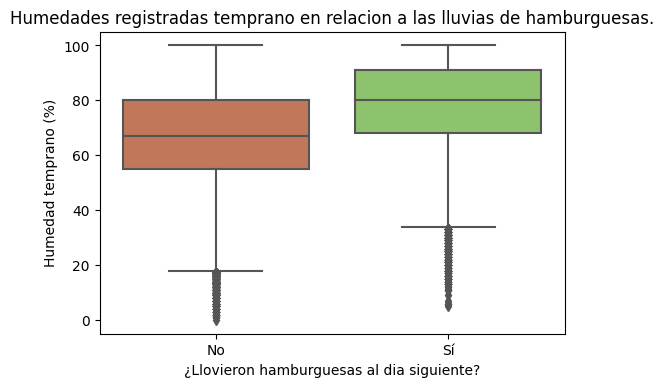

In [37]:
plt.figure(dpi=100)
plt.title("Humedades registradas temprano en relacion a las lluvias de hamburguesas.")
sns.boxplot(
    data=df,
    y='humedad_temprano',
    x='llovieron_hamburguesas_al_dia_siguiente',
    palette=['#D17049', "#89D15E"],
)
plt.xlabel('¿Llovieron hamburguesas al dia siguiente?')
plt.ylabel("Humedad temprano (%)")
plt.xticks([False, True], ["No", "Sí"])
plt.show()

Se puede notar que se repite esta relación entre la alta humedad de un dia y la elevada chance de que llueva al dia siguiente, auque la diferencia no es tan marcada como en el caso anterior.

Como se ve en el gráfico, la mediana en el caso 'si' es muy cercana al tercer cuartil del caso 'no', con un valor cercano a 80%. Para valores mayores a este consideramos que aumenta la probabilidad de lluvia de hamburguesas al día siguiente

## 5. ¿Como se relaciona la nubosidad con la lluvia de hamburguesas?


La nubosidad se mide en porciones de cielo siendo cubierto por las nubes, de a octavos u "octas". Por ejemplo, si las nubes cubren la mitad del cielo se dice que la nubosidad es de 4 octas.

Graficamos su distribución utilizando un histograma.

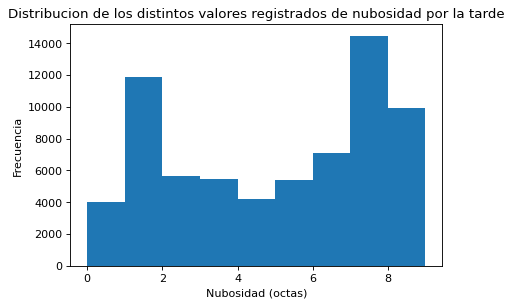

In [38]:
plt.figure(dpi=80)
df['nubosidad_tarde'].plot(
    kind='hist',
    bins=9,
    title='Distribucion de los distintos valores registrados de nubosidad por la tarde'
)
plt.xlabel('Nubosidad (octas)')
plt.ylabel('Frecuencia')
plt.show()

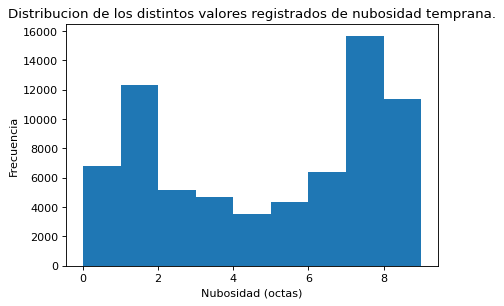

In [39]:
plt.figure(dpi=80)
df['nubosidad_temprano'].plot(
    kind='hist',
    bins=9,
    title='Distribucion de los distintos valores registrados de nubosidad temprana.'
)
plt.xlabel('Nubosidad (octas)')
plt.ylabel('Frecuencia')
plt.show()

Vemos que la nubosidad, tanto tarde como temprano, tienen una distribución de forma irregular, con picos alrededor de 1, 7 y 8.

Dada la distribucion particular que poseen estas variables, vamos a utilizar un violin plot para visualizar como afecta la nubosidad a la lluvia de hamburguesas al dia siguiente.

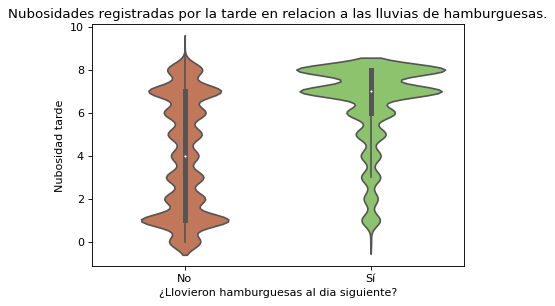

In [40]:
plt.figure(dpi=80)
plt.title("Nubosidades registradas por la tarde en relacion a las lluvias de hamburguesas.")
sns.violinplot(
    data=df,
       
    y='nubosidad_tarde',
    x='llovieron_hamburguesas_al_dia_siguiente',
    palette=['#D17049', "#89D15E"],
)
plt.xlabel('¿Llovieron hamburguesas al dia siguiente?')
plt.ylabel("Nubosidad tarde")
plt.xticks([False, True], ["No", "Sí"])
plt.show()

Podemos ver que los valores de cuando sí llueve al dia siguiente se concentran en particular cuando la nubosidad de la tarde es entre 6 y 8 octas, es decir, con nubosidades elevadas a la tarde, hay una alta probabilidad de que lluevan hamburguesas al dia siguiente. Por otro lado, los niveles de nubosidad cuando no llueven hamburguesas tienen una distribución más uniforme.

Ahora vemos la relación entre la nubosidad temprana con la variable target.

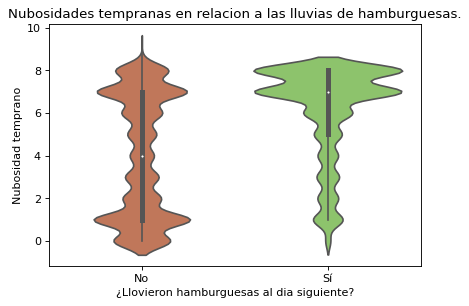

In [41]:
plt.figure(dpi=80)
plt.title("Nubosidades tempranas en relacion a las lluvias de hamburguesas.")
sns.violinplot(
    data=df,
       
    y='nubosidad_temprano',
    x='llovieron_hamburguesas_al_dia_siguiente',
    palette=['#D17049', "#89D15E"],
)
plt.xlabel('¿Llovieron hamburguesas al dia siguiente?')
plt.ylabel("Nubosidad temprano")
plt.xticks([False, True], ["No", "Sí"])
plt.show()

Observando ambos graficos, podemos notar que la mediana de la nubosidad al llover hamburguesas al dia siguiente coincide con el tercer cuartil de los casos cuando no.

Por lo tanto, concluimos que una nubosidad elevada (mayor que 6 octas) indica una mayor probabilidad de lluvia de hamburguesas al día siguiente

## 6. ¿Como se relaciona el viento con la lluvia de hamburguesas?


Nos preguntamos como afecta el comportamiento del viento en general a nuestra maquina de lluvia de hamburguesas. En el dataset hay 6 columnas con datos del viento: direccion del viento por la tarde, direccion del viento temprano, direccion de las rafagas de viento maximas, velocidad de las rafagas de viento maximas, velocidad del viento por la tarde y velocidad del viento temprano. 

Ahora visualizaremos las relaciones entre las distintas direcciones del viento y las veces que llueven hamburguesas al dia siguiente.

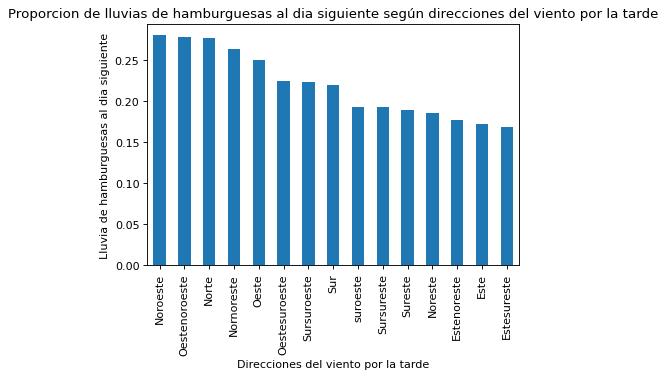

In [42]:
plt.figure(dpi=80)
((df[df['llovieron_hamburguesas_al_dia_siguiente'] == 'si'].groupby('direccion_viento_tarde').size())/(df.groupby('direccion_viento_tarde').size())).sort_values(ascending=False).plot(
    kind='bar',
    xlabel='Direcciones del viento por la tarde',
    ylabel='Lluvia de hamburguesas al dia siguiente',
    title='Proporcion de lluvias de hamburguesas al dia siguiente según direcciones del viento por la tarde'
)
plt.show()


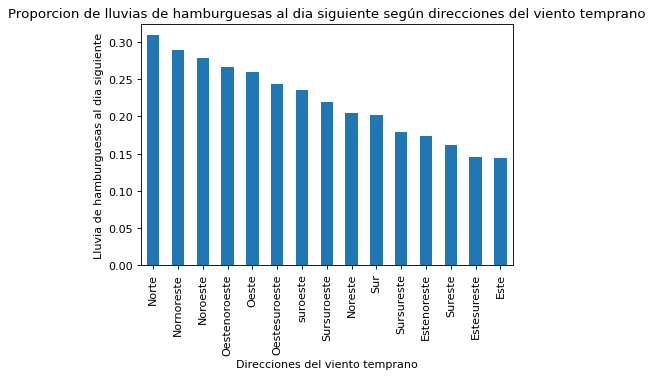

In [43]:
plt.figure(dpi=80)
((df[df['llovieron_hamburguesas_al_dia_siguiente'] == 'si'].groupby('direccion_viento_temprano').size())/(df.groupby('direccion_viento_temprano').size())).sort_values(ascending=False).plot(
    kind='bar', 
    xlabel='Direcciones del viento temprano',
    ylabel='Lluvia de hamburguesas al dia siguiente',
    title='Proporcion de lluvias de hamburguesas al dia siguiente según direcciones del viento temprano'
)
plt.show()

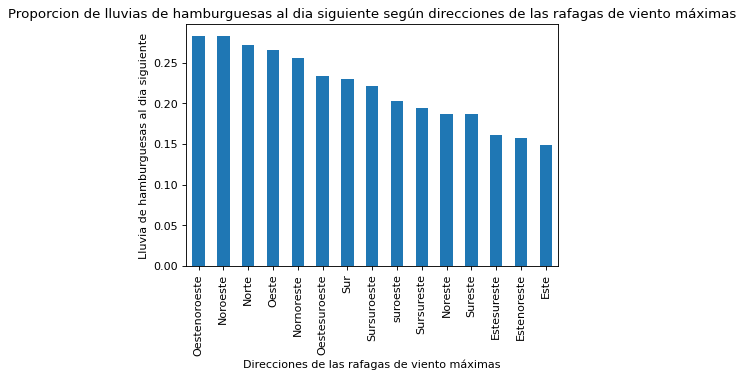

In [44]:
plt.figure(dpi=80)
((df[df['llovieron_hamburguesas_al_dia_siguiente'] == 'si'].groupby('rafaga_viento_max_direccion').size())/(df.groupby('rafaga_viento_max_direccion').size())).sort_values(ascending=False).plot(
    kind='bar',
    xlabel='Direcciones de las rafagas de viento máximas',
    ylabel='Lluvia de hamburguesas al dia siguiente',
    title='Proporcion de lluvias de hamburguesas al dia siguiente según direcciones de las rafagas de viento máximas'
)
plt.show()

Luego de visualizar los ultimos gráficos, podemos concluir que cuando la direccion del viento se concentra hacia el Norte, Noroeste y Oestenoroeste, aumenta levemente la probabilidad de lluvia de hamburguesas al día siguiente.

Ahora analizamos la relacion entre las velocidades de las maximas rafagas de viento y las lluvias de hamburguesas.

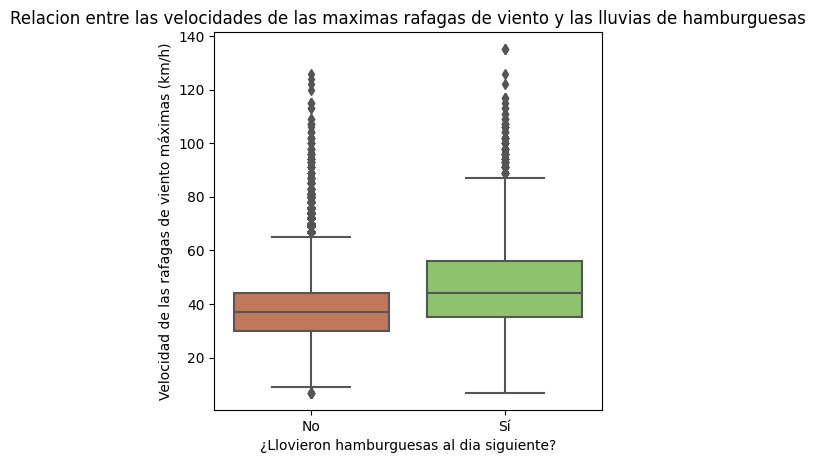

In [45]:
plt.figure(dpi=100, figsize=(5,5))
plt.title("Relacion entre las velocidades de las maximas rafagas de viento y las lluvias de hamburguesas")
sns.boxplot(
    data=df,
       
    y='rafaga_viento_max_velocidad',
    x='llovieron_hamburguesas_al_dia_siguiente',
    palette=['#D17049', "#89D15E"],
)
plt.xlabel('¿Llovieron hamburguesas al dia siguiente?')
plt.ylabel("Velocidad de las rafagas de viento máximas (km/h)")
plt.xticks([False, True], ["No", "Sí"])
plt.show()

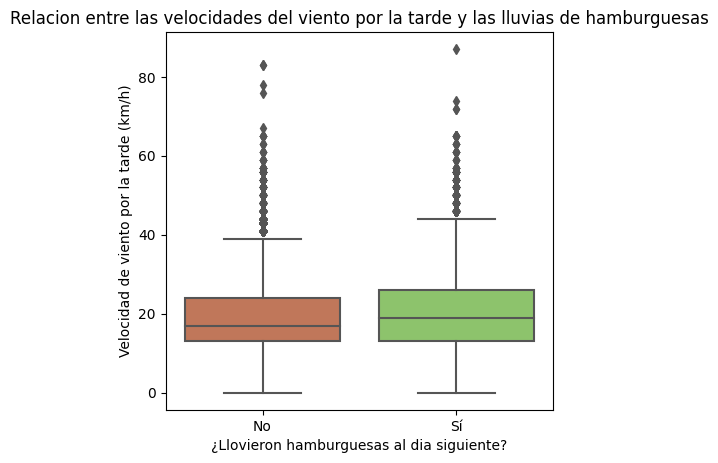

In [46]:
plt.figure(dpi=100, figsize=(5,5))
plt.title("Relacion entre las velocidades del viento por la tarde y las lluvias de hamburguesas")
sns.boxplot(
    data=df,
       
    y='velocidad_viendo_tarde',
    x='llovieron_hamburguesas_al_dia_siguiente',
    palette=['#D17049', "#89D15E"],
)
plt.xlabel('¿Llovieron hamburguesas al dia siguiente?')
plt.ylabel("Velocidad de viento por la tarde (km/h)")
plt.xticks([False, True], ["No", "Sí"])
plt.show()

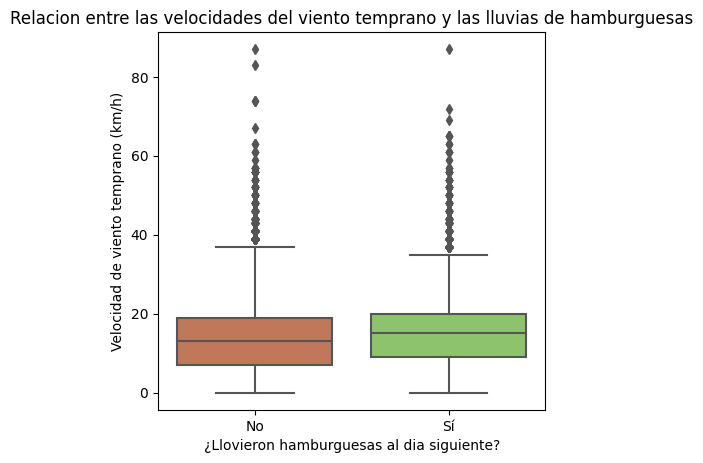

In [47]:
plt.figure(dpi=100, figsize=(5,5))
plt.title("Relacion entre las velocidades del viento temprano y las lluvias de hamburguesas")
sns.boxplot(
    data=df,
       
    y='velocidad_viendo_temprano',
    x='llovieron_hamburguesas_al_dia_siguiente',
    palette=['#D17049', "#89D15E"],
)
plt.xlabel('¿Llovieron hamburguesas al dia siguiente?')
plt.ylabel("Velocidad de viento temprano (km/h)")
plt.xticks([False, True], ["No", "Sí"])
plt.show()

Podemos notar que cuanto mayor es la velocidad de las rafagas de viento, mayor es la probabilidad de lluvia de hamburguesas, particularmente para valores mayores a 45 km/h. Aparte, nuevamente podemos ver que la mediana de los casos en los que sí llueve al dia siguiente coincide con el tercer cuartil de los casos en los que no, como con la nubosidad. 
La velocidad del viento tarde y temprano no parecen tener relación con la lluvia de hamburguesas al día siguiente.

## 7.¿Como se relaciona la presión atmosférica con la lluvia de hamburguesas?

Analizamos la distribución de la presión atmosférica, medida en hPa. 

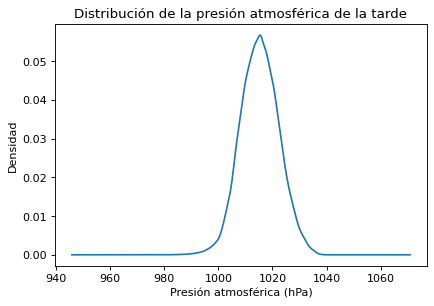

In [48]:
plt.figure(dpi=80)
df['presion_atmosferica_tarde'].plot(kind='density', title='Distribución de la presión atmosférica de la tarde')
plt.xlabel('Presión atmosférica (hPa)')
plt.ylabel('Densidad')
plt.show()


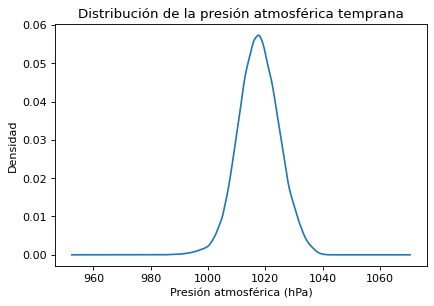

In [49]:
plt.figure(dpi=80)
df['presion_atmosferica_temprano'].plot(kind='density', title='Distribución de la presión atmosférica temprana')
plt.xlabel('Presión atmosférica (hPa)')
plt.ylabel('Densidad')
plt.show()

Vemos que la presion atmosferica no varia mucho respecto de los valores estándares de presión al nivel del mar. También observamos que la presión por la tarde es, en promedio, levemente menor que la presión por la mañana.

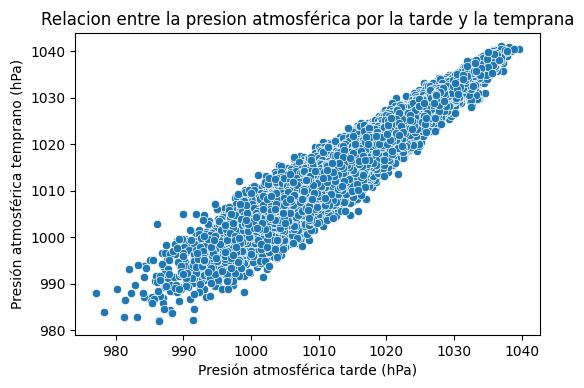

In [50]:
plt.figure(dpi=100)
sns.scatterplot(
    x=df['presion_atmosferica_tarde'],
    y=df['presion_atmosferica_temprano']
)
plt.xlabel('Presión atmosférica tarde (hPa)')
plt.ylabel('Presión atmosférica temprano (hPa)')
plt.title('Relacion entre la presion atmosférica por la tarde y la temprana')
plt.show()

Además se observa que la presión atmosférica de la tarde está altamente correlacionada con la presión atmosférica temprana, con lo cual no suele variar mucho durante el día.

Ahora analizaremos cómo depende la presión atmosférica de la tarde con la lluvia de hamburguesas al día siguiente.

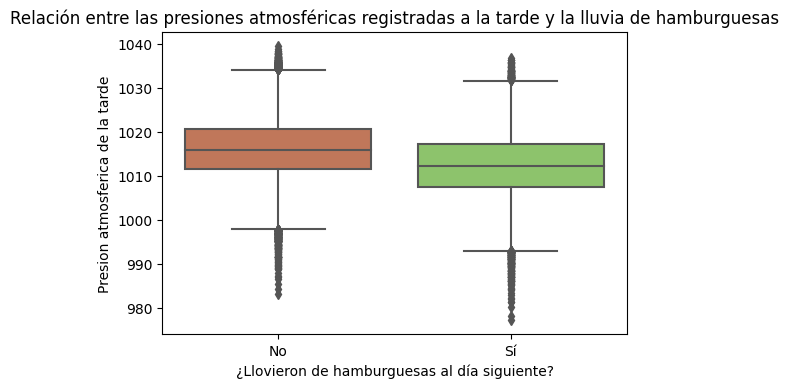

In [51]:
plt.figure(dpi=100)
plt.title("Relación entre las presiones atmosféricas registradas a la tarde y la lluvia de hamburguesas")
sns.boxplot(
    data=df,
       
    y='presion_atmosferica_tarde',
    x='llovieron_hamburguesas_al_dia_siguiente',
    palette=['#D17049', "#89D15E"],
)
plt.xlabel("¿Llovieron de hamburguesas al día siguiente?")
plt.ylabel("Presion atmosferica de la tarde")
plt.xticks([False, True], ["No", "Sí"])
plt.show()

Podemos ver que la presión atmosférica de la tarde tiende a ser ligeramente menor cuando llueven hamburguesas al día siguiente. En particular, cuando es menor a 1011 hPa.

## 8.¿Como se relaciona los milimetros evaporados de agua con la lluvia de hamburguesas?

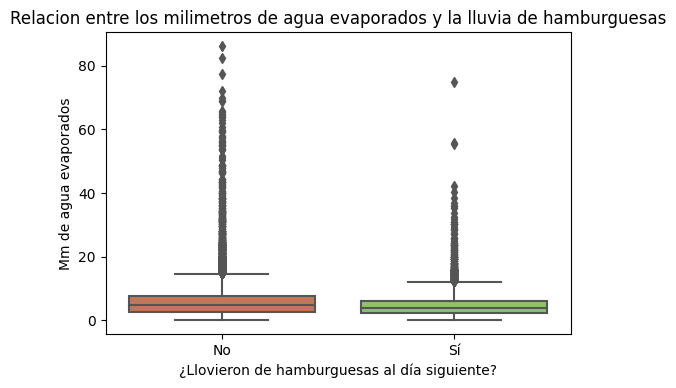

In [52]:
plt.figure(dpi=100)
plt.title("Relacion entre los milimetros de agua evaporados y la lluvia de hamburguesas")
sns.boxplot(
    data=df,
       
    y='mm_evaporados_agua',
    x='llovieron_hamburguesas_al_dia_siguiente',
    palette=['#D17049', "#89D15E"],
)
plt.xlabel("¿Llovieron de hamburguesas al día siguiente?")
plt.ylabel("Mm de agua evaporados")
plt.xticks([False, True], ["No", "Sí"])
plt.show()

Al igual que en el análisis de los mm de lluvia, vemos una gran cantidad de outliers con valores altos, los cuales corresponden a los eventos donde la cantidad de lluvia caída fue muy alta.

Al agrupar los datos según la lluvia de hamburguesas al día siguiente, no se observan diferencias significativas entre los dos casos.

## 9.¿Como se relaciona las horas de sol con la lluvia de hamburguesas?

Graficamos, con el fin de observar como la cantidad de horas de sol afecta el comportamiento de la maquina de lluvia de hamburguesas, la relacion entre estas dos variables.

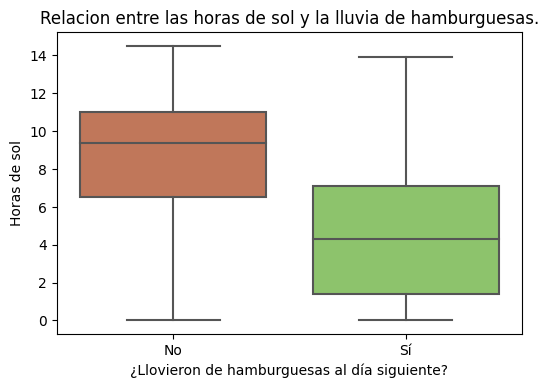

In [53]:
plt.figure(dpi=100)
plt.title("Relacion entre las horas de sol y la lluvia de hamburguesas.")
sns.boxplot(
    data=df,
       
    y='horas_de_sol',
    x='llovieron_hamburguesas_al_dia_siguiente',
    palette=['#D17049', "#89D15E"],
)
plt.xlabel("¿Llovieron de hamburguesas al día siguiente?")
plt.ylabel("Horas de sol")
plt.xticks([False, True], ["No", "Sí"])
plt.show()

Las horas de sol por dia varían segun la estación y la epoca del año. Es por eso que esta variable esta fuertemente ligada a las fechas en las que es registrada. Su correlación con el comportamiento de la maquina de lluvia de hamburguesas se asemeja a aquel de las fechas. Como podemos observar, cuanto menor es la cantidad de horas de sol, mayor es la probabilidad de que lluevan hamburguesas al dia siguiente.

## 10.¿Como varía el clima segun el barrio?

Graficamos la proporción de veces que llovieron hamburguesas en cada barrio respecto de la cantidad total de muestras tomadas por barrio. Comparamos ordenando de forma descendente.

<Figure size 12000x24000 with 0 Axes>

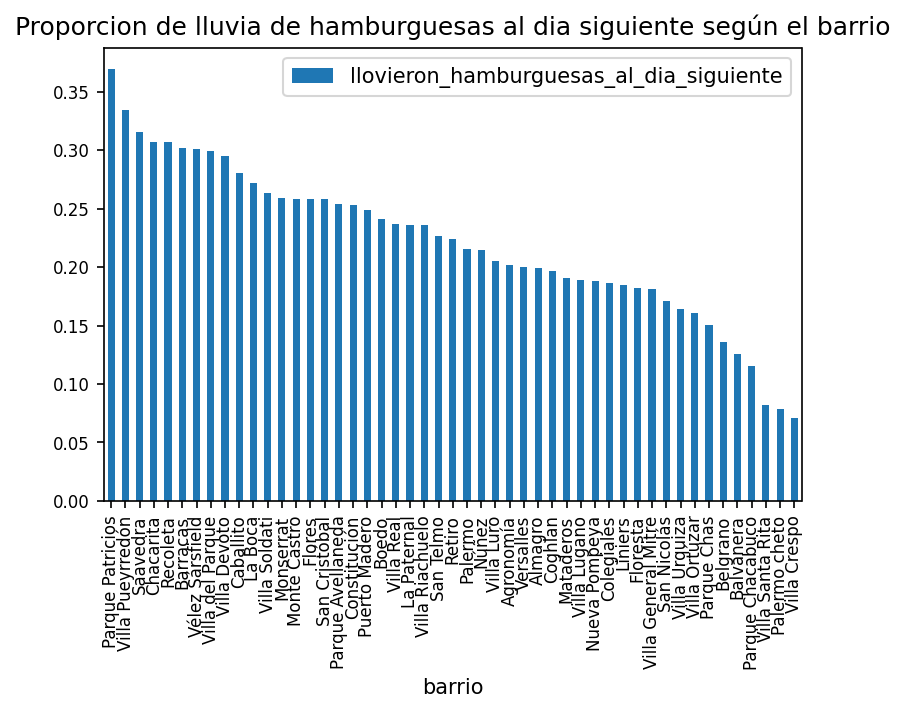

In [54]:
plt.figure(dpi=120, figsize=(100, 200))
lluvia_por_barrios = df[['barrio', 'llovieron_hamburguesas_al_dia_siguiente']][df['llovieron_hamburguesas_al_dia_siguiente']=='si'].groupby('barrio').count()

lluvia_por_barrios /=  df[['barrio', 'llovieron_hamburguesas_al_dia_siguiente']].groupby('barrio').count()

lluvia_por_barrios.sort_values(by = 'llovieron_hamburguesas_al_dia_siguiente', ascending=False).plot(kind = 'bar', title='Proporcion de lluvia de hamburguesas al dia siguiente según el barrio', fontsize=8)

plt.show()

Notamos que en los barrios Villa Crespo, Palermo Cheto y Villa Santa Rita llovieron hamburguesas menos veces que en el resto de los barrios. Por otro lado, los barrios Parque Patricios y Villa Pueyrredón registraron la mayor cantidad de lluvias de hamburguesas.

Graficamos el promedio de horas de sol por barrio, y notamos que en varios no se tomaron datos de dicho atributo. Además notamos que los barrios en los cuales hubo menor cantidad de lluvia de hamburguesas son donde más horas de sol se registraron, lo cual coincide con el análisis de la sección anterior.

<Figure size 720x480 with 0 Axes>

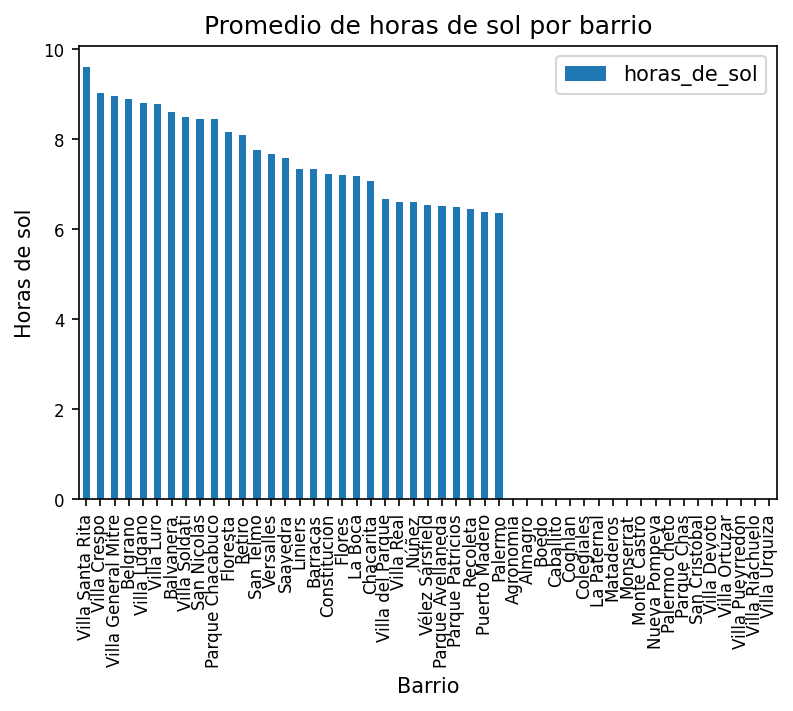

In [55]:
plt.figure(dpi=120)

df[['barrio', 'horas_de_sol']].groupby('barrio').mean().sort_values(by = 'horas_de_sol', ascending=False).plot(kind = 'bar', title='Promedio de horas de sol por barrio', fontsize=8)
plt.xlabel('Barrio')
plt.ylabel('Horas de sol')
plt.show()

Lo mismo sucede con los mm de lluvia evaporados:

<Figure size 720x480 with 0 Axes>

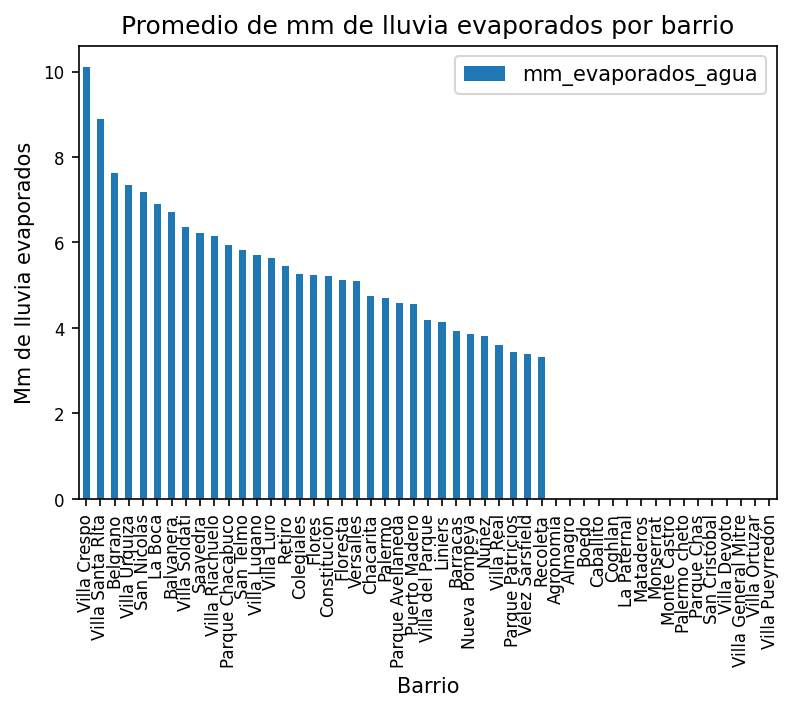

In [56]:
plt.figure(dpi=120)

df[['barrio', 'mm_evaporados_agua']].groupby('barrio').mean().sort_values(by = 'mm_evaporados_agua', ascending=False).plot(kind = 'bar', title='Promedio de mm de lluvia evaporados por barrio', fontsize=8)
plt.xlabel('Barrio')
plt.ylabel('Mm de lluvia evaporados')
plt.show()

Hacemos el mismo analisis que el anterior, pero con los atributos 'humedad_tarde' y 'humedad_temprana'.

<Figure size 720x480 with 0 Axes>

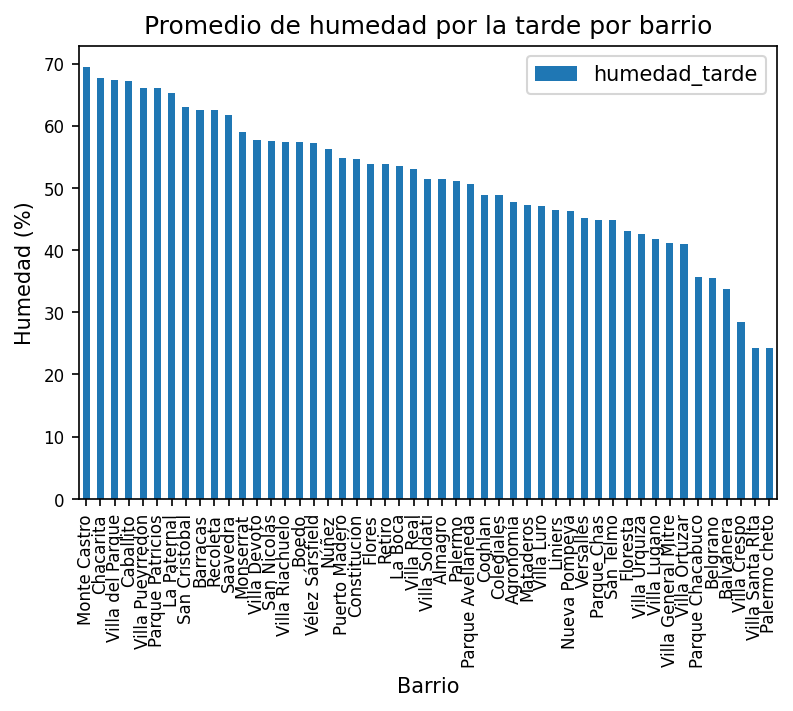

In [57]:
plt.figure(dpi=120)

df[['barrio', 'humedad_tarde']].groupby('barrio').mean().sort_values(by = 'humedad_tarde', ascending=False).plot(kind = 'bar', title='Promedio de humedad por la tarde por barrio', fontsize=8)
plt.xlabel('Barrio')
plt.ylabel('Humedad (%)')
plt.show()

<Figure size 720x480 with 0 Axes>

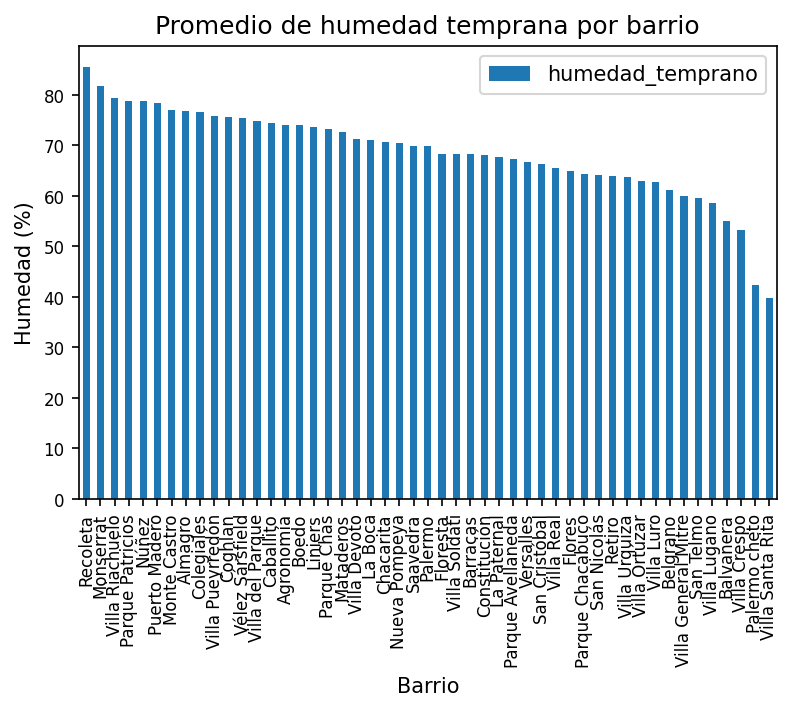

In [58]:
plt.figure(dpi=120)

df[['barrio', 'humedad_temprano']].groupby('barrio').mean().sort_values(by = 'humedad_temprano', ascending=False).plot(kind = 'bar', title='Promedio de humedad temprana por barrio', fontsize=8)
plt.xlabel('Barrio')
plt.ylabel('Humedad (%)')
plt.show()

<Figure size 720x480 with 0 Axes>

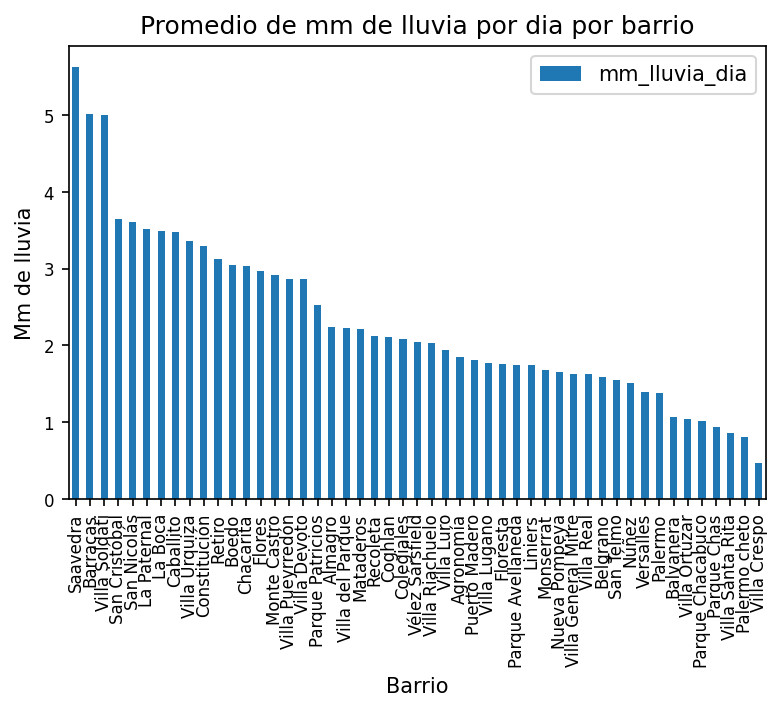

In [59]:
plt.figure(dpi=120)
df[['barrio', 'mm_lluvia_dia']].groupby('barrio').mean().sort_values(by = 'mm_lluvia_dia', ascending=False).plot(kind = 'bar', title='Promedio de mm de lluvia por dia por barrio', fontsize=8)
plt.xlabel('Barrio')
plt.ylabel('Mm de lluvia')
plt.show()

Graficando los mm de lluvia diarios observamos que, nuevamente, los barrios Villa Santa Rita, Palermo Cheto y Villa Crespo son donde menos llovió.

Ahora graficamos la temperatura de la tarde:

<Figure size 720x480 with 0 Axes>

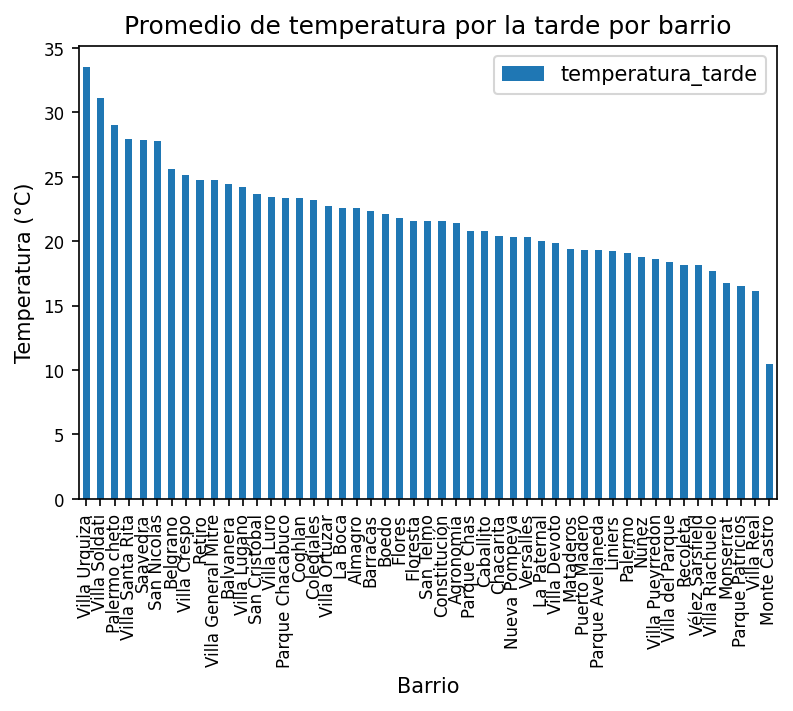

In [60]:
plt.figure(dpi=120)

df[['barrio', 'temperatura_tarde']].groupby('barrio').mean().sort_values(by = 'temperatura_tarde', ascending=False).plot(kind = 'bar', title='Promedio de temperatura por la tarde por barrio', fontsize=8)
plt.xlabel('Barrio')
plt.ylabel('Temperatura (°C)')
plt.show()

Observamos que los barrios donde se registraron las mayores temperaturas son Villa Urquiza, Villa Soldati y Palermo cheto, mientras que las menores temperaturas se registraron en Monte Castro, Villa Real y Parque Patricios.

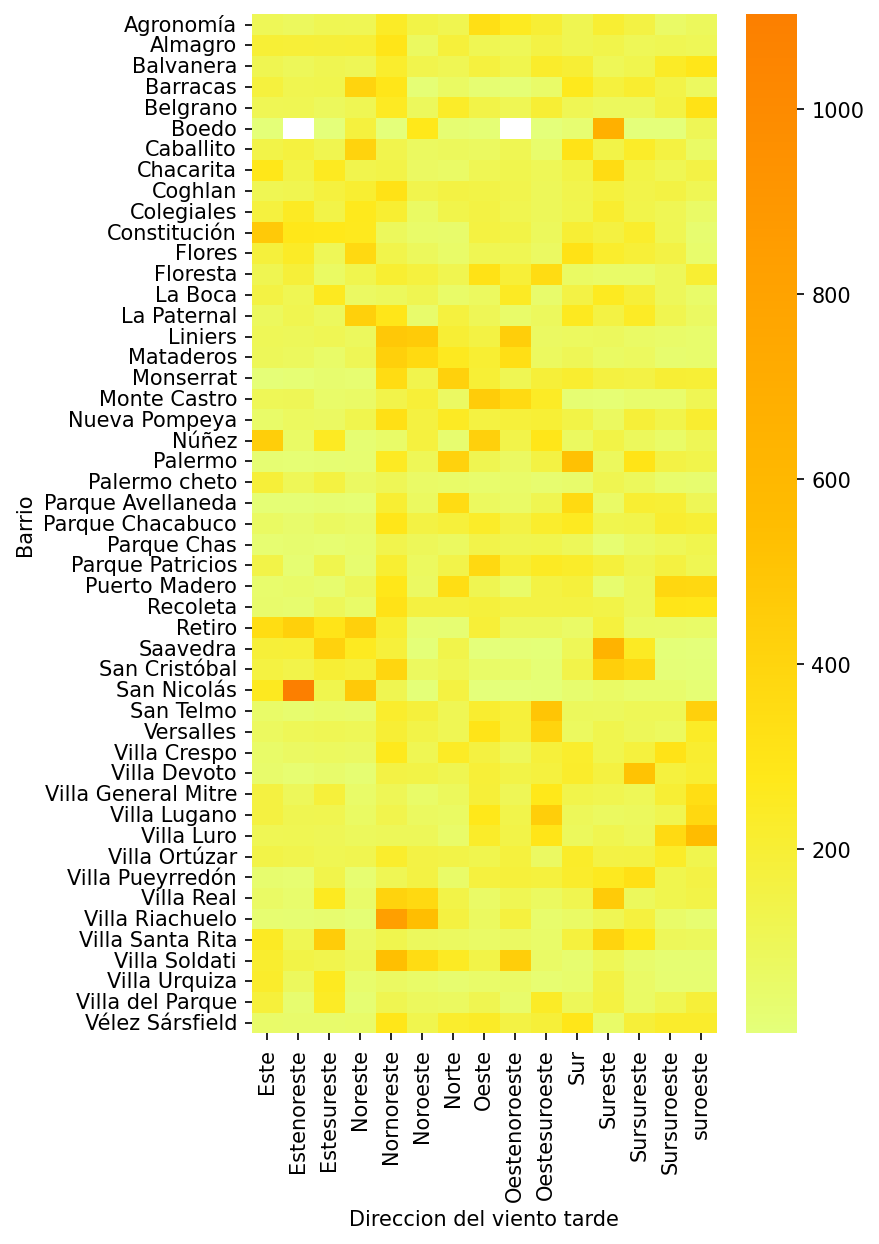

In [61]:
plt.figure(figsize=(5, 9))
sns.heatmap(pd.pivot_table(df, index='barrio', columns='direccion_viento_tarde',aggfunc='size'),
            xticklabels=True,
            yticklabels=True,
            cmap='Wistia'
           )
plt.xlabel('Direccion del viento tarde')
plt.ylabel('Barrio')         
plt.show()


No econtramos ningun patrón entre las variables barrio y direccion viento tarde.

En conclusión, analizando el clima en los distintos barrios, notamos en primer lugar que hay barrios donde no se registraron ciertos datos, como las horas de sol y los milímetros de lluvia evaporados. Tambien vimos que las diferencias en variables como la temperatura y los milímetros diarios de lluvia entre los distintos barrios coinciden con las diferencias en la lluvia de hamburguesas, en forma consistente con los analisis hechos en las secciones anteriores. Creemos entonces que es probable que las diferencias en la lluvia de hamburguesas entre los distintos barrios se presentan por sus características climáticas registradas. 

## 11.¿Cómo varia el clima según la fecha?


<Figure size 480x320 with 0 Axes>

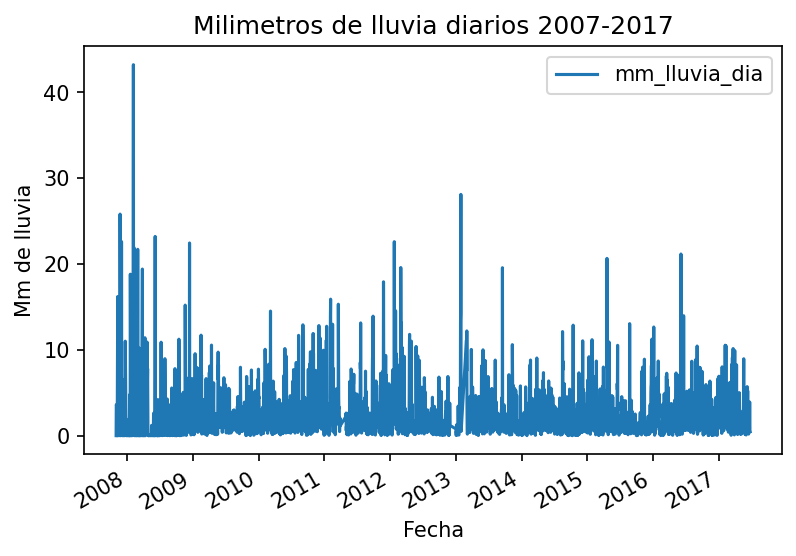

In [62]:
plt.figure(dpi=80)
df[['dia', 'mm_lluvia_dia']].groupby('dia').mean().plot(
    kind='line',
    title='Milimetros de lluvia diarios 2007-2017',
)
plt.xlabel('Fecha')
plt.ylabel('Mm de lluvia')
plt.show()

<Figure size 480x320 with 0 Axes>

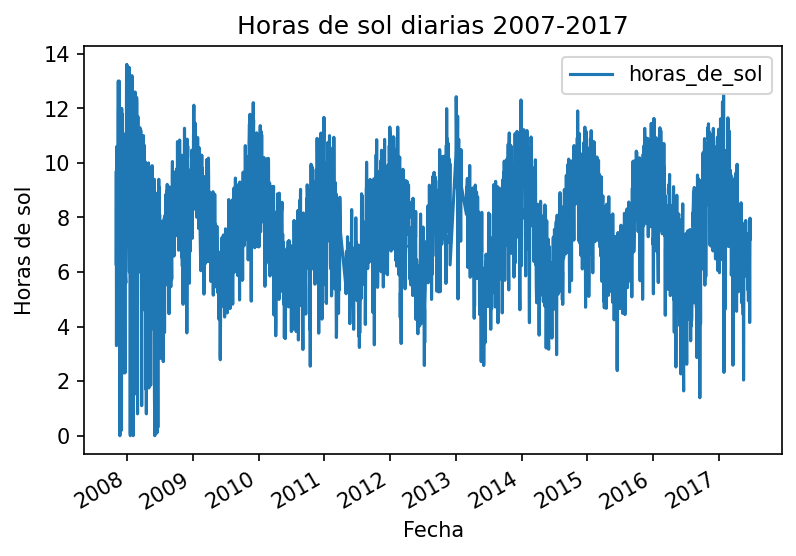

In [63]:
plt.figure(dpi=80)

df[['dia', 'horas_de_sol']].groupby('dia').mean().plot(
    kind='line',
    title='Horas de sol diarias 2007-2017',
)
plt.xlabel('Fecha')
plt.ylabel('Horas de sol')
plt.show()

<Figure size 480x320 with 0 Axes>

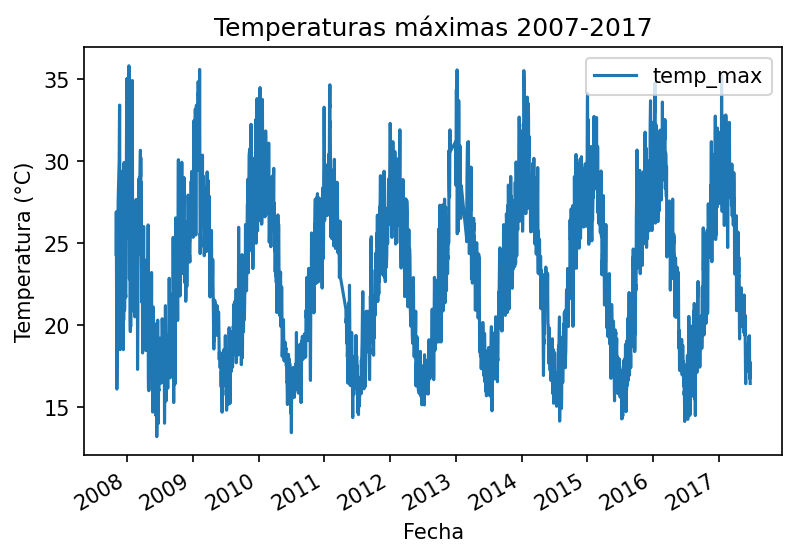

In [64]:
plt.figure(dpi=80)

df[['dia', 'temp_max']].groupby('dia').mean().plot(
    kind='line',
    title='Temperaturas máximas 2007-2017',
)
plt.xlabel('Fecha')
plt.ylabel('Temperatura (°C)')
plt.show()

Observando los gráficos, no notamos ningún patrón en los milímetros de lluvia con respecto al tiempo, pero en variables como las horas de sol y la temperatura se notan claramente las fluctuaciones debidas a las estaciones del año.

Ahora analizaremos si hay algún patrón temporal en la lluvia de hamburguesas:

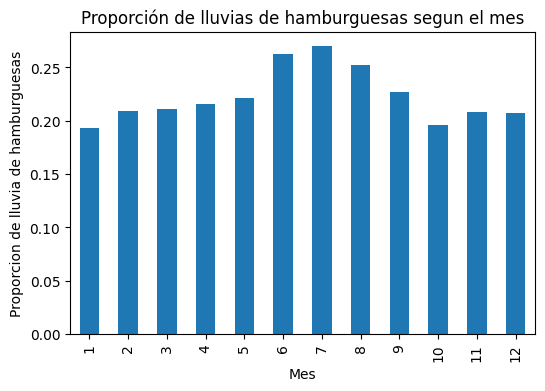

In [65]:
plt.figure(dpi=100)

((df[df['llovieron_hamburguesas_al_dia_siguiente'] == 'si'].groupby(df['dia'].dt.month).size())/(df.groupby(df['dia'].dt.month).size())).plot(
    kind='bar',
    title='Proporción de lluvias de hamburguesas segun el mes'
)
plt.xlabel('Mes')
plt.ylabel('Proporcion de lluvia de hamburguesas')
plt.show()

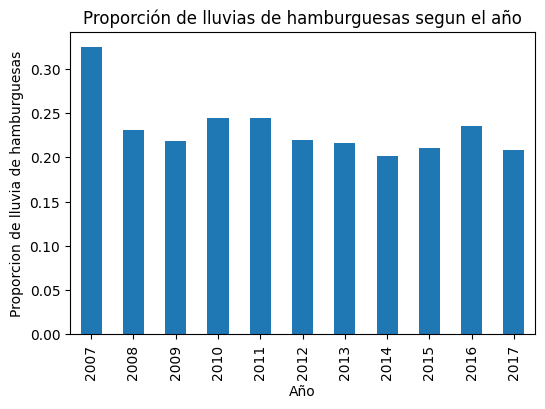

In [66]:
plt.figure(dpi=100)

((df[df['llovieron_hamburguesas_al_dia_siguiente'] == 'si'].groupby(df['dia'].dt.year).size())/(df.groupby(df['dia'].dt.year).size())).plot(
    kind='bar',
    title='Proporción de lluvias de hamburguesas segun el año'
)
plt.xlabel('Año')
plt.ylabel('Proporcion de lluvia de hamburguesas')
plt.show()

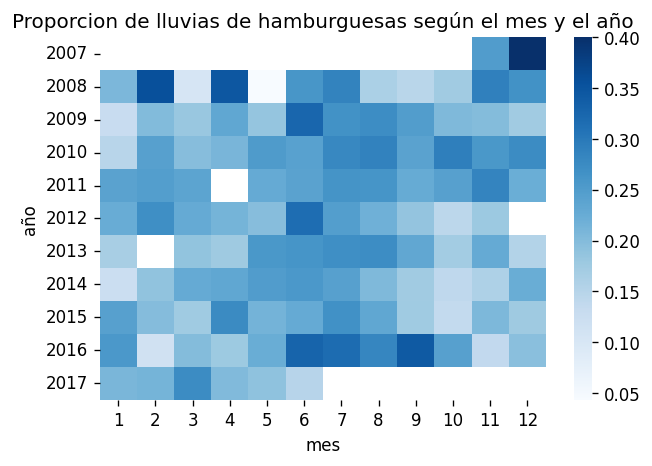

In [67]:
plt.figure(dpi=120)
mes_anio = ((df[df['llovieron_hamburguesas_al_dia_siguiente'] == 'si'].groupby([df['dia'].dt.month, df['dia'].dt.year]).size())/(df.groupby([df['dia'].dt.month, df['dia'].dt.year]).size())).rename_axis(['mes','año']).to_frame()
mes_anio.columns = ['llovieron_hamburguesas_al_dia_siguiente']
mes_anio = mes_anio.reset_index(level=[0,1])
sns.heatmap(pd.pivot_table(mes_anio, index='año', columns='mes', values='llovieron_hamburguesas_al_dia_siguiente'), cmap='Blues')
plt.title('Proporcion de lluvias de hamburguesas según el mes y el año')
plt.show()

A partir de los gráficos anteriores, sacamos como conclusión que es más probable que llueva hamburguesas durante los meses junio, julio y agosto. 

Además, en los siguientes meses en particular se registraron proporciones más altas que lo normal: diciembre de 2007, febrero de 2008, abril de 2008 y septiembre de 2006.

## Conclusiones

Entre todas las variables analizadas, la que observamos que tiene más alta correlación con la lluvia de hamburguesas al día siguiente es la humedad de la tarde. Consideramos que la humedad de la tarde elevada es la condición principal para predecir si van a llover hamburguesas.

Otras condiciones que consideramos importantes son la lluvia de hamburguesas del día anterior, la velocidad del viento, los milímetros de lluvia, la humedad temprano, la nubosidad y las horas de sol.

Consideramos que estas variables definen la probabilidad de lluvia de hamburguesas, mientras que las variaciones observadas en función de otras variables como los barrios y las fechas son consecuencia de las variables nombradas anteriormente. Por ejemplo, las horas de sol están íntimamente relacionadas con la época del año, y es por eso que en ciertos meses llueve más que en otros.

# Baseline

A partir de estas consideraciones armamos el baseline. Dado que la variable target es 'no' en el 77.6% de los casos, inicialmente completamos con ceros la lista de predicciones. Con esto se logra un accuracy de 77.6%. Luego, a partir de las observaciones realizadas, definimos una condicion booleana y marcamos con 1 las celdas que cumplen esta condición, con el objetivo de aumentar el accuracy del baseline.

In [68]:
def baseline(X: pd.DataFrame) -> list[int]:
    
    # Creamos una columna nueva para guardar las predicciones, y la llenamos con 0 inicialmente
    X['prediccion'] = 0

    
    # Ingenieria de features:
    X.loc[X['llovieron_hamburguesas_al_dia_siguiente'] == 'si' , 'llovieron_hamburguesas_al_dia_siguiente'] = 1
    X.loc[X['llovieron_hamburguesas_al_dia_siguiente'] == 'no' , 'llovieron_hamburguesas_al_dia_siguiente'] = 0
    X['presion_atmosferica_tarde'] = pd.to_numeric(X['presion_atmosferica_tarde'], errors='coerce')
    X.dropna(subset=['llovieron_hamburguesas_al_dia_siguiente'], inplace=True)
    X = X[X.isnull().mean(1) < 0.4]
    
    
    # Condiciones
    c1 = X['humedad_tarde'] > 80
    c2 = X['humedad_tarde'] > 60
    c3 = X['llovieron_hamburguesas_hoy'] == 'si'
    c4 = X['rafaga_viento_max_velocidad'] > 45
    c5 = X['mm_lluvia_dia'] > 6.07
    c6 = X['humedad_temprano'] > 80
    c7 = X['horas_de_sol'] < 6
    c8 = X['nubosidad_tarde'] > 6
    
    condicion = c1 | (c2 & c3 & c4) | (c3 & c5 & c6 & c7 & c8)

    
    # Llenamos con 1 las celdas que satisfacen la condicion
    X.loc[condicion , 'prediccion'] = 1
    
    
    return X['prediccion'].tolist()

Cargamos el dataframe original:

In [69]:
df_orig = df_features.merge(df_target, left_on='id', right_on='id')
df_orig = df_orig[df_orig.isnull().mean(1) < 0.4]

Llamamos a la función baseline y calculamos el accuracy:

In [70]:
prediccion = baseline(df_orig)

accuracy = (df_orig['llovieron_hamburguesas_al_dia_siguiente'] == prediccion).mean().round(4)

print(f"Accuracy = {accuracy}")

Accuracy = 0.8329
